In [24]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Path to models

In [25]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

# Number of dynamic classes

In [26]:
NUM_CLASSES = 6

# Count of points

In [27]:
TIME_STEPS = 16
DIMENSION = 2

# Load dataset

In [28]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [29]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Select model

In [ ]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        '''
        Build your model there
        '''
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        '''
        Build your model there
        '''
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

/home/kira/anaconda3/envs/diplom/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.summary()  

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [ ]:
# Customizing model parameters
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [35]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - accuracy: 0.2266 - loss: 1.8236
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2140 - loss: 1.8225 - val_accuracy: 0.1037 - val_loss: 1.7800
Epoch 2/1000
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2109 - loss: 1.7945
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1925 - loss: 1.7955 - val_accuracy: 0.1341 - val_loss: 1.7692
Epoch 3/1000
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1328 - loss: 1.7785
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1600 - loss: 1.7798 - val_accuracy: 0.1585 - val_loss: 1.7588
Epoch 4/1000
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1406 - loss: 1.7864
Epoch 4: saving model to model/point_history_classifier/

In [ ]:
# Loading a saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[0.00409913 0.47895896 0.46946606 0.02681989 0.01680601 0.00385001]
1


# confusion matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


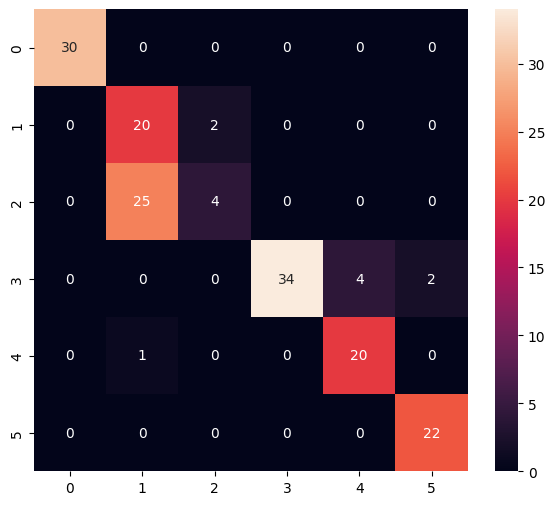

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.43      0.91      0.59        22
           2       0.67      0.14      0.23        29
           3       1.00      0.85      0.92        40
           4       0.83      0.95      0.89        21
           5       0.92      1.00      0.96        22

    accuracy                           0.79       164
   macro avg       0.81      0.81      0.76       164
weighted avg       0.83      0.79      0.77       164



In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite

In [ ]:
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [40]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, 
    tf.lite.OpsSet.SELECT_TF_OPS     
]

converter._experimental_lower_tensor_list_ops = False

tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpv65f3wr0/assets


INFO:tensorflow:Assets written to: /tmp/tmpv65f3wr0/assets


Saved artifact at '/tmp/tmpv65f3wr0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135679498073872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135679498073296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135679498062544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135679498072912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135679498072720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135680954220176: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1745873740.918577  125668 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745873740.918590  125668 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-28 23:55:40.918735: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpv65f3wr0
2025-04-28 23:55:40.919282: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-28 23:55:40.919291: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpv65f3wr0
2025-04-28 23:55:40.921757: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-28 23:55:40.935577: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpv65f3wr0
2025-04-28 23:55:40.939651: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 20918 microseconds.
